In [14]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import transpile

1 - layer QGB

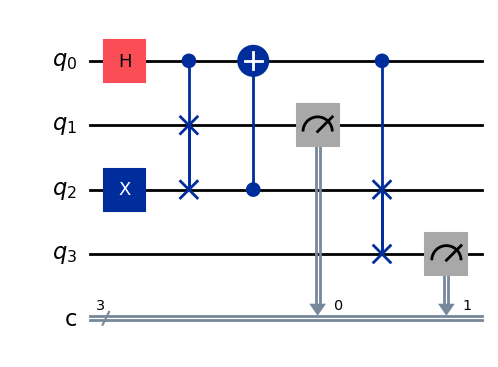

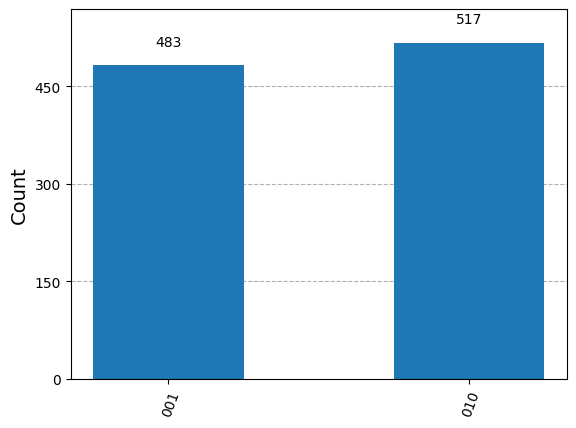

In [15]:
# 1 coin qubit + 3 position qubits, 3 classical bits
qc = QuantumCircuit(4, 3)  # q[0]=coin, q[1:4]=positions

qc.x(2)
qc.h(0)

qc.append(CSwapGate(), [0, 1, 2])
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])

qc.measure(1, 0)
qc.measure(3, 1)

# Show circuit diagram
qc.draw('mpl')
plt.show()

# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
# Show result
plot_histogram(counts)
plt.show()


2 - layer QGB

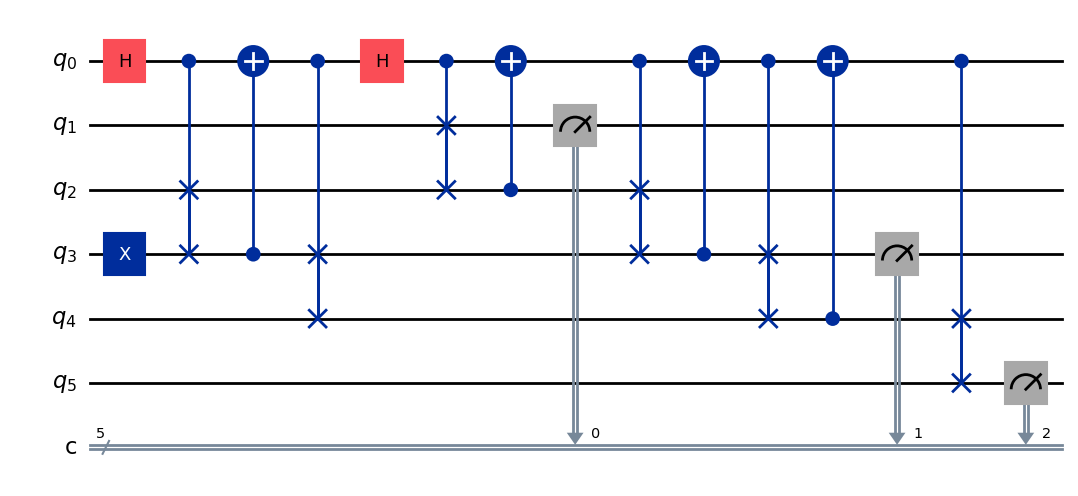

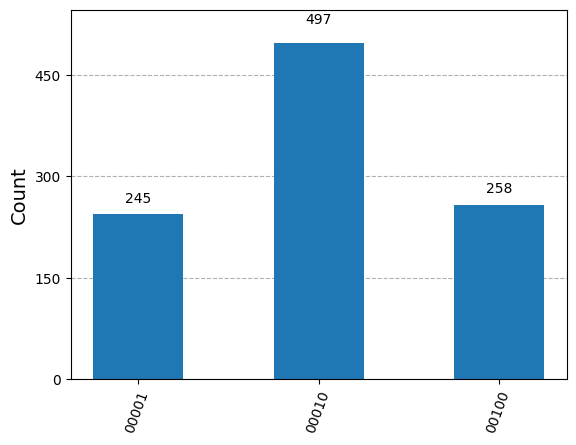

In [16]:
# 1 coin qubit + 5 position qubits, and 5 classical bits
qc = QuantumCircuit(6, 5)

# Naming: q[0] = coin, q[1]–q[5] = position qubits

# Initial position: put particle at center (q[3])
qc.x(3)

# === Layer 1 ===
qc.h(0)  # Hadamard on coin
qc.append(CSwapGate(), [0, 2, 3]) 
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])  

# === Layer 2 ===
qc.h(0)
qc.append(CSwapGate(), [0, 1, 2])  
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])   
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4]) 
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5]) 


# Measure all position qubits
qc.measure(1, 0)
qc.measure(3, 1)
qc.measure(5, 2)

# Show the circuit
qc.draw('mpl')
plt.show()

# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)
plt.show()

3 - layer QGB

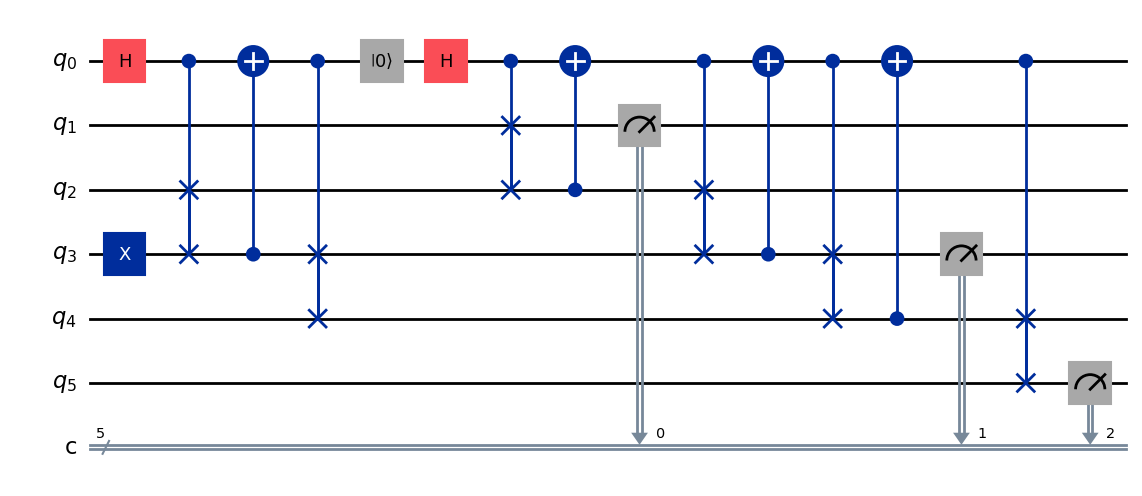

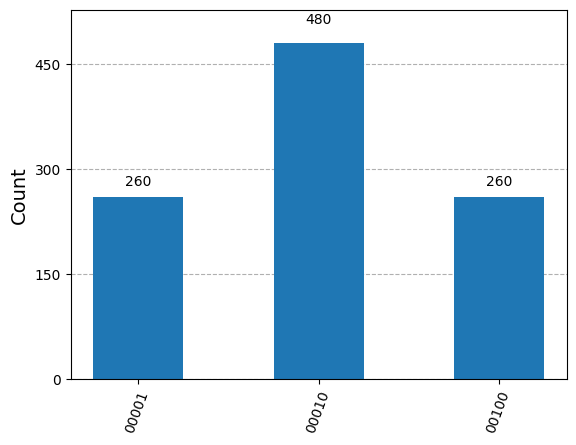

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# 1 coin qubit + 5 position qubits, and 5 classical bits
qc = QuantumCircuit(6, 5)

# Naming: q[0] = coin, q[1]–q[5] = position qubits

# Initial position: put particle at center (q[3])
qc.x(3)

# === Layer 1 ===
qc.h(0)  # Hadamard on coin
qc.append(CSwapGate(), [0, 2, 3]) 
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])  

# === Reset coin qubit (q[0]) to |0⟩ ===
qc.reset(0)

# === Layer 2 ===
qc.h(0)
qc.append(CSwapGate(), [0, 1, 2])  
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])   
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4]) 
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5]) 

# Measure selected position qubits
qc.measure(1, 0)
qc.measure(3, 1)
qc.measure(5, 2)

# Show the circuit
qc.draw('mpl')
plt.show()

# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)
plt.show()


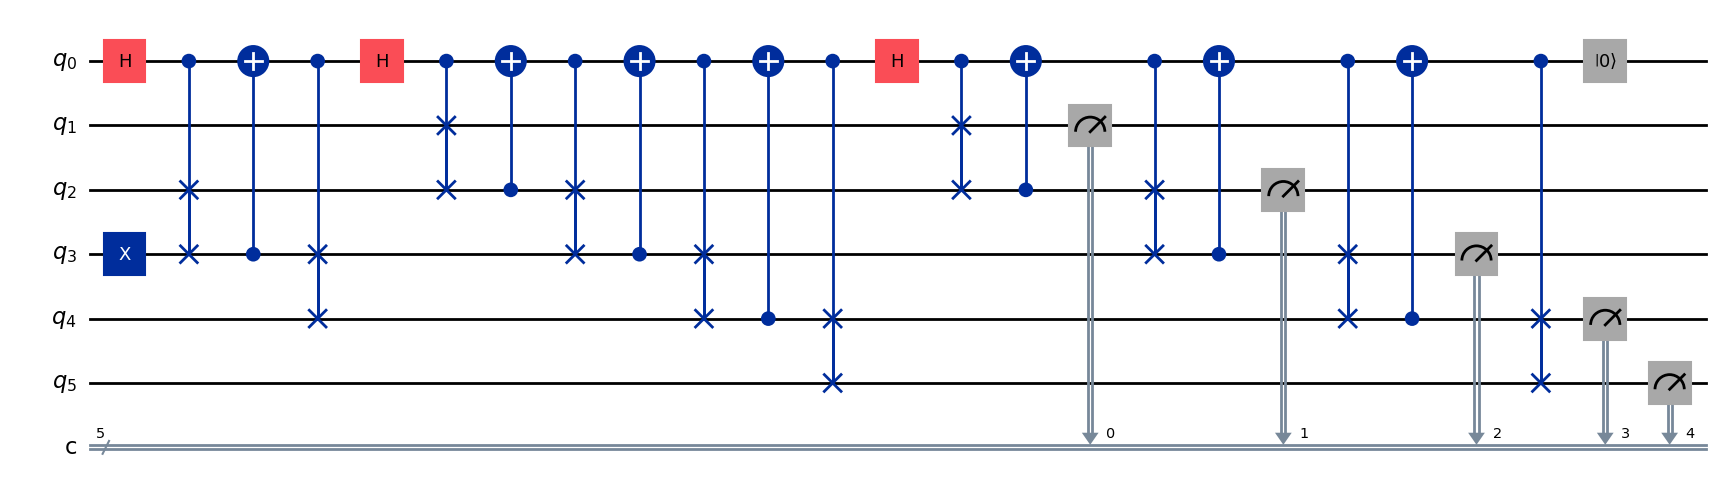

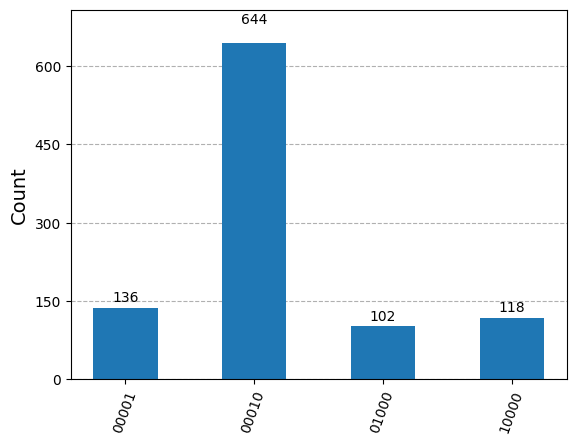

In [18]:
# 1 coin + 5 position qubits, 5 classical bits
qc = QuantumCircuit(6, 5)

# Initial position: place particle at center (q[3])
qc.x(3)

# === Layer 1 ===
qc.h(0)                             # Hadamard on coin
qc.append(CSwapGate(), [0, 2, 3])   # swap q2 and q3 if coin is 1
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])   # swap q3 and q4 if coin is 1

# === Layer 2 ===
qc.h(0)
qc.append(CSwapGate(), [0, 1, 2])
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5])

# === Layer 3 ===
qc.h(0)
qc.append(CSwapGate(), [0, 1, 2])
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5])

# === Reset coin qubit to |0⟩ ===
qc.reset(0)

# Measure relevant position qubits (avoid conflict)
qc.measure(1, 0)  # leftmost
qc.measure(2, 1)
qc.measure(3, 2)  # center
qc.measure(4, 3)
qc.measure(5, 4)  # rightmost

# Visualize circuit
qc.draw('mpl')
plt.show()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)
plt.show()


n - layer QGB generalisation

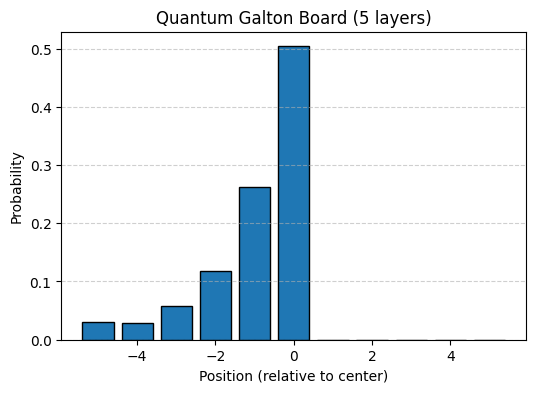

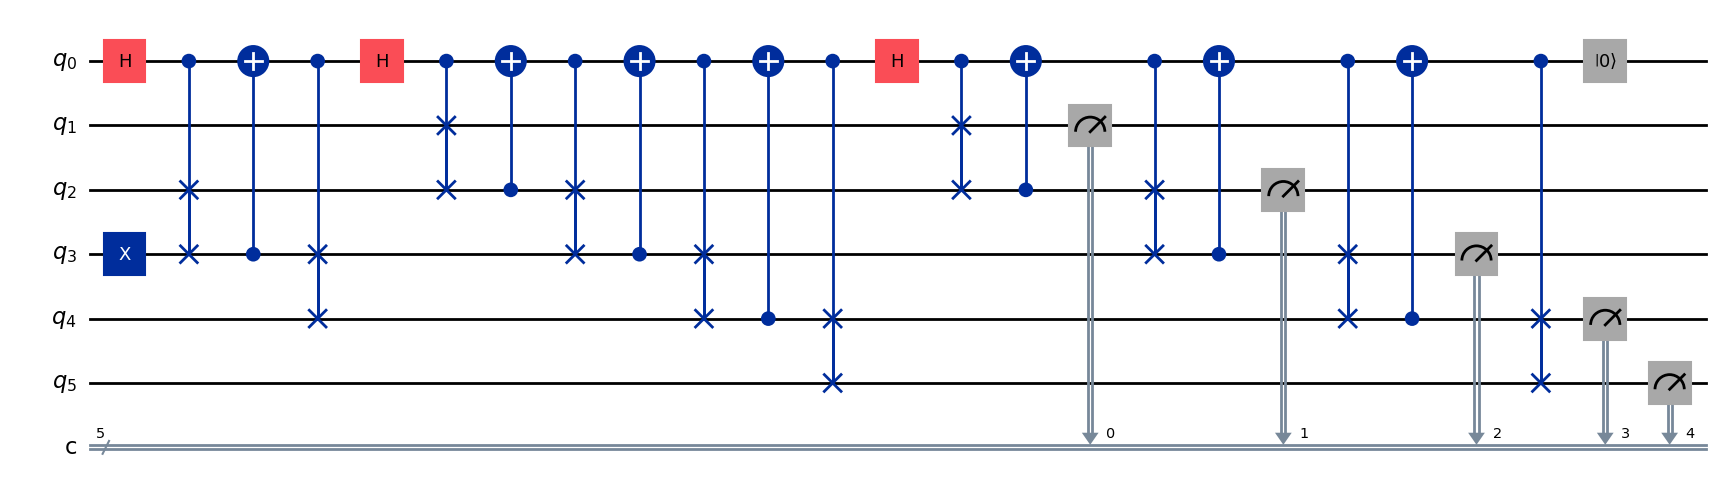

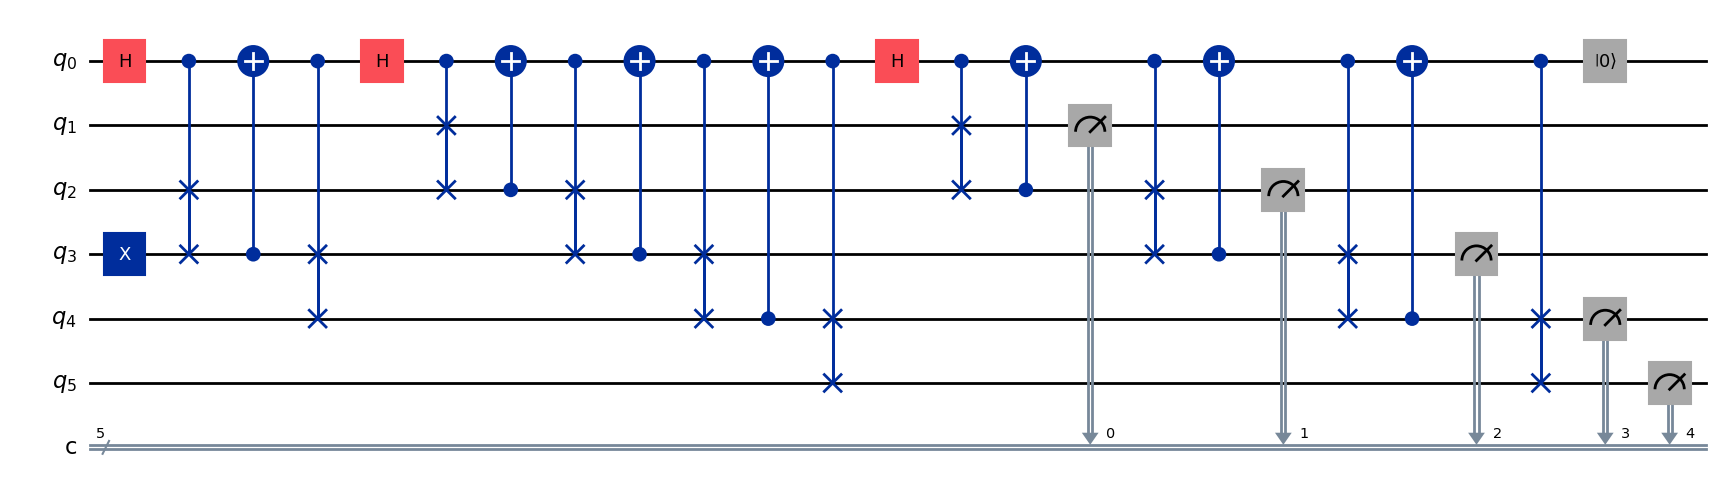

In [19]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

def generate_galton_circuit(n_layers: int) -> QuantumCircuit:
    """
    Build an n-layer quantum Galton board using one-hot encoding,
    with a fresh coin qubit for each layer (to avoid reset).
    - coin qubits: q[0] ... q[n_layers-1]
    - position qubits: q[n_layers] ... q[n_layers + (2*n_layers+1) - 1]
    - classical bits: 2*n_layers + 1
    """
    n_pos = 2*n_layers + 1
    total_qubits = n_layers + n_pos
    qc = QuantumCircuit(total_qubits, n_pos)

    # offset where position register begins
    pos0 = n_layers
    center = n_layers  # center index in the pos register

    # Initialize the walker at the center position
    qc.x(pos0 + center)

    # For each layer, use a fresh coin qubit
    for layer in range(n_layers):
        coin = layer
        # 1) coin flip
        qc.h(coin)
        # 2) conditional left move: swap center-(layer) <-> center-(layer+1)
        qc.append(
            CSwapGate(),
            [coin,
             pos0 + center - layer,
             pos0 + center - layer - 1]
        )
        # 3) conditional right move: swap center+layer <-> center+layer+1
        qc.append(
            CSwapGate(),
            [coin,
             pos0 + center + layer,
             pos0 + center + layer + 1]
        )
        # leave coin untouched thereafter

    # Measure all position qubits into classical bits [0..n_pos-1]
    for i in range(n_pos):
        qc.measure(pos0 + i, i)

    return qc

def run_and_plot(n_layers: int, shots: int = 2048):
    """
    Generate, simulate, and plot the output distribution
    of the n-layer quantum Galton board.
    """
    qc = generate_galton_circuit(n_layers)
    sim = AerSimulator()
    qc_compiled = transpile(qc, sim)
    counts = sim.run(qc_compiled, shots=shots).result().get_counts()

    # Convert one-hot counts → position histogram
    n_pos = 2*n_layers + 1
    pos_counts = [0]*n_pos
    for bitstr, cnt in counts.items():
        # Qiskit bitstr is c[n_pos-1]...c[0]; we wrote c[i]←pos0+i
        # Find which classical bit is '1'
        # Rightmost bit of bitstr is c[0], next is c[1], etc.
        for i in range(n_pos):
            if bitstr[-1 - i] == '1':
                pos_counts[i] += cnt
                break

    # Normalize
    total = sum(pos_counts)
    pos_probs = [c/total for c in pos_counts]

    # Plot
    positions = list(range(-n_layers, n_layers+1))
    plt.figure(figsize=(6,4))
    plt.bar(positions, pos_probs, edgecolor='k')
    plt.xlabel('Position (relative to center)')
    plt.ylabel('Probability')
    plt.title(f'Quantum Galton Board ({n_layers} layers)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    return pos_probs

if __name__ == "__main__":
    # Try it for 5 layers
    run_and_plot(n_layers=5, shots=4096)
    
qc.draw('mpl')
